In [1]:
# Imports

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.model_selection import train_test_split

In [2]:
# Importing training data

train_data1 = np.load('../DL-Project/data0.npy')
train_lab1 = np.load('../DL-Project/lab0.npy')

train_data2 = np.load('../DL-Project/data1.npy')
train_lab2 = np.load('../DL-Project/lab1.npy')

train_data3 = np.load('../DL-Project/data2.npy')
train_lab3 = np.load('../DL-Project/lab2.npy')


In [3]:
# Preprocessing - normalizing the image and adding new dimension for convolutions

images = np.concatenate((train_data1, train_data2, train_data3)) / 255
labels = np.concatenate((train_lab1, train_lab2, train_lab3))

images = images[:, np.newaxis, :, :]
# labels = np.eye(40)[labels]

In [4]:
np.shape(images)

(30000, 1, 40, 168)

In [5]:
np.shape(labels)

(30000,)

In [6]:
labels[0]

np.uint8(25)

In [7]:
# Splitting the dataset into train, validate and test sets

train_images, temp_images, train_labels, temp_labels = train_test_split(
    images, labels, test_size=0.2, random_state=100
)
val_images, test_images, val_labels, test_labels = train_test_split(
    temp_images, temp_labels, test_size=0.5, random_state=100
)

In [8]:
# Converting the sets to pytorch compatible tensors

train_images = torch.tensor(train_images, dtype=torch.float32)
train_labels = torch.tensor(train_labels, dtype=torch.float32)
val_images = torch.tensor(val_images, dtype=torch.float32)
val_labels = torch.tensor(val_labels, dtype=torch.float32)
test_images = torch.tensor(test_images, dtype=torch.float32)
test_labels = torch.tensor(test_labels, dtype=torch.float32)

In [9]:
# Creating the Datasets from the tensors

class ImageDataset(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

train_dataset = ImageDataset(train_images, train_labels)
val_dataset = ImageDataset(val_images, val_labels)
test_dataset = ImageDataset(test_images, test_labels)

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
# Choosing GPU for training

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [38]:
# Defining the model and moving it to the gpu

class CNNRegressor(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolution layer 1
            nn.Conv2d(1, 10, kernel_size=28, stride=1, padding=14),  # (N, 10, 40, 168)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 10, 20, 84)
            # Convolution layer 2
            nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=1),  # (N, 16, 20, 84)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 16, 10, 42)
            # Convolution layer 3
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (N, 32, 10, 42)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 32, 5, 21)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            # Fully connected layer 1
            nn.Linear(32 * 5 * 21, 256),
            nn.ReLU(),
            
            # # Fully connected layer 2
            # nn.Linear(256, 64),
            # nn.ReLU(),
            # # Fully connected layer 3
            # nn.Linear(64, 40),
            # nn.ReLU(),
            
            # Fully connected layer 2
            nn.Linear(256, 32),
            nn.ReLU(),
            # Fully connected layer 3
            nn.Linear(32, 4),
            nn.ReLU(),
            # Fully connected layer 4
            nn.Linear(4, 20),
            nn.ReLU(),
            # Fully connected layer 5
            nn.Linear(20, 40),
            nn.ReLU(),
            
            # Final layer for output
            # nn.Linear(4, 1)  # Regression output
        )

    def forward(self, x):
        # Running the convolution layers
        x = self.conv_layers(x)
        # Running the fully connected layers
        x = self.fc_layers(x)
        return x

model = CNNRegressor().to(device)

In [39]:
# Defining Loss and Optimizer
criterion = nn.CrossEntropyLoss() # Cross Entropy loss is the mean absolute error
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [40]:
# TQDM to keep track of the training
from tqdm import tqdm

In [41]:
# Defining the training Loop

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    train_losses = []
    validation_losses = []
    
    for epoch in tqdm(range(epochs)):
        
        model.train()
        train_loss = 0
        for images, labels in train_loader:
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)
            # labels = labels.unsqueeze(1)  # Match output shape
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        val_loss = 0
        model.eval()
        with torch.no_grad():
            for images, labels in val_loader:
                labels = labels.type(torch.LongTensor)
                images, labels = images.to(device), labels.to(device)
                # labels = labels.unsqueeze(1)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        train_losses.append(train_loss/len(train_loader))
        validation_losses.append(val_loss/len(val_loader))
        
        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {validation_losses[-1]:.4f}")

    return (train_losses, validation_losses)


In [42]:
# Training the model for 15 initial epochs

train_losses, validation_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15)

  7%|███████████▊                                                                                                                                                                     | 1/15 [01:24<19:37, 84.09s/it]

Epoch 1/15, Train Loss: 3.6072, Val Loss: 3.5813


 13%|███████████████████████▌                                                                                                                                                         | 2/15 [02:48<18:16, 84.36s/it]

Epoch 2/15, Train Loss: 3.5765, Val Loss: 3.5811


 20%|███████████████████████████████████▍                                                                                                                                             | 3/15 [04:13<16:54, 84.54s/it]

Epoch 3/15, Train Loss: 3.5764, Val Loss: 3.5812


 27%|███████████████████████████████████████████████▏                                                                                                                                 | 4/15 [05:38<15:31, 84.65s/it]

Epoch 4/15, Train Loss: 3.5763, Val Loss: 3.5811


 33%|███████████████████████████████████████████████████████████                                                                                                                      | 5/15 [07:03<14:07, 84.70s/it]

Epoch 5/15, Train Loss: 3.5765, Val Loss: 3.5813


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 6/15 [08:28<12:44, 84.90s/it]

Epoch 6/15, Train Loss: 3.5764, Val Loss: 3.5816


 47%|██████████████████████████████████████████████████████████████████████████████████▌                                                                                              | 7/15 [09:53<11:20, 85.06s/it]

Epoch 7/15, Train Loss: 3.5764, Val Loss: 3.5814


 53%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                  | 8/15 [11:19<09:56, 85.17s/it]

Epoch 8/15, Train Loss: 3.5763, Val Loss: 3.5810


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 9/15 [12:44<08:31, 85.23s/it]

Epoch 9/15, Train Loss: 3.5763, Val Loss: 3.5814


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                          | 10/15 [14:09<07:06, 85.28s/it]

Epoch 10/15, Train Loss: 3.5763, Val Loss: 3.5814


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                               | 11/15 [15:35<05:41, 85.32s/it]

Epoch 11/15, Train Loss: 3.5764, Val Loss: 3.5815


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 12/15 [17:00<04:16, 85.34s/it]

Epoch 12/15, Train Loss: 3.5764, Val Loss: 3.5814


 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 13/15 [18:26<02:50, 85.37s/it]

Epoch 13/15, Train Loss: 3.5762, Val Loss: 3.5811


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 14/15 [19:51<01:25, 85.38s/it]

Epoch 14/15, Train Loss: 3.5763, Val Loss: 3.5811


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [21:16<00:00, 85.13s/it]

Epoch 15/15, Train Loss: 3.5762, Val Loss: 3.5810


In [43]:
# Training the model for 35 more epochs

# train_losses, validation_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=35)

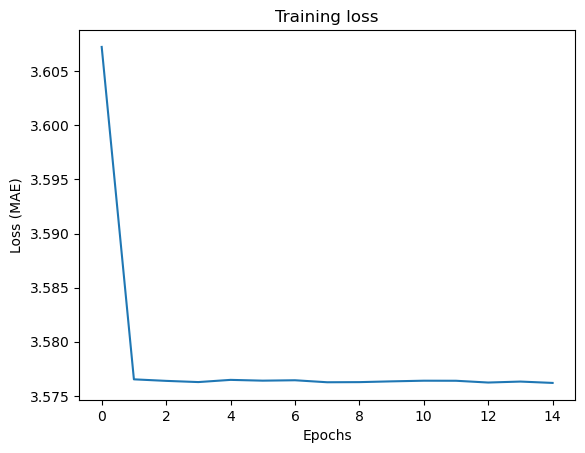

In [44]:
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.title("Training loss")
plt.show()

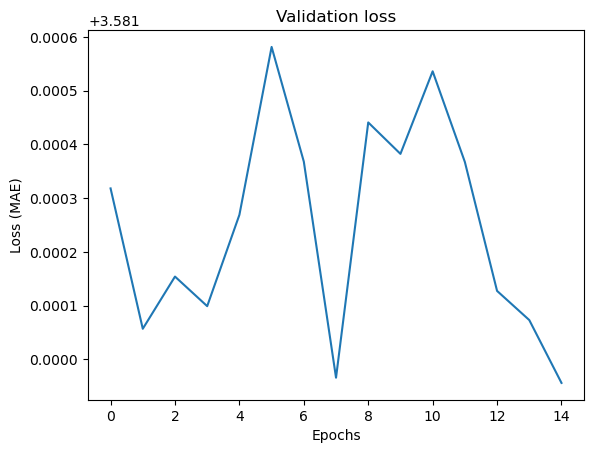

In [45]:
plt.plot(validation_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.title("Validation loss")
plt.show()

In [47]:
# Save the model

torch.save(model.state_dict(), "model.pth")

In [46]:
# Testing the Model on the test dataset with L1 loss

l1l = nn.L1Loss()

def evaluate_model_L1(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # labels = labels.unsqueeze(1)
            outputs = model(images)
            argmax_outputs = torch.argmax(outputs, dim=1)
            loss = l1l(argmax_outputs, labels)
            test_loss += loss.item()
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    return [labels, outputs]

l,o = evaluate_model(model, test_loader)


Test Loss: 3.5894


In [48]:
# Testing the Model on the test dataset

def evaluate_model_CE(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            labels = labels.type(torch.LongTensor)
            images, labels = images.to(device), labels.to(device)
            # labels = labels.unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    return [labels, outputs]

l,o = evaluate_model(model, test_loader)

Test Loss: 3.5894


In [49]:
# Testing accuracy

def evaluate_accuracy(model, test_loader):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            # labels = labels.unsqueeze(1)
            outputs = model(images)
            argmax_outputs = torch.argmax(outputs, dim=1)
            correct_predictions = (argmax_outputs == labels).sum().item()
            test_loss += correct_predictions
    # print(f"Test Loss: {test_loss/len(test_loader):.4f}")
    print("Accuracy:", test_loss/len(test_dataset))
    return [labels, outputs]

l,o = evaluate_accuracy(model, test_loader)

Accuracy: 0.056


In [35]:
# train_losses, validation_losses = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)
# evaluate_accuracy(model, test_loader)

 10%|█████████████████▋                                                                                                                                                               | 1/10 [01:23<12:32, 83.63s/it]

Epoch 1/10, Train Loss: 3.2654, Val Loss: 3.2458


 20%|███████████████████████████████████▍                                                                                                                                             | 2/10 [02:47<11:10, 83.79s/it]

Epoch 2/10, Train Loss: 3.1889, Val Loss: 3.1969


 30%|█████████████████████████████████████████████████████                                                                                                                            | 3/10 [04:11<09:47, 83.87s/it]

Epoch 3/10, Train Loss: 3.1225, Val Loss: 3.2082


 40%|██████████████████████████████████████████████████████████████████████▊                                                                                                          | 4/10 [05:36<08:24, 84.13s/it]

Epoch 4/10, Train Loss: 3.0689, Val Loss: 3.1931


 50%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                        | 5/10 [07:00<07:01, 84.28s/it]

Epoch 5/10, Train Loss: 3.0237, Val Loss: 3.2503


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                      | 6/10 [08:25<05:37, 84.38s/it]

Epoch 6/10, Train Loss: 2.9701, Val Loss: 3.2077


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 7/10 [09:49<04:13, 84.42s/it]

Epoch 7/10, Train Loss: 2.9039, Val Loss: 3.2748


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 8/10 [11:14<02:48, 84.46s/it]

Epoch 8/10, Train Loss: 2.8397, Val Loss: 3.3007


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 9/10 [12:39<01:24, 84.59s/it]

Epoch 9/10, Train Loss: 2.7648, Val Loss: 3.4181


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [14:04<00:00, 84.41s/it]

Epoch 10/10, Train Loss: 2.6947, Val Loss: 3.4474


Accuracy: 0.13066666666666665


[tensor([13.,  8., 22., 11., 15., 19., 18., 15., 14., 28., 12., 16., 23., 23.,
         15., 17., 12., 30., 15., 19., 15., 14., 19., 13.], device='cuda:0'),
 tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 2.2608, 0.0000, 0.0000, 3.1178, 1.7488, 0.5503, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.9094, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0

In [37]:
l,o = evaluate_model(model, test_loader)

Test Loss: 3.4369


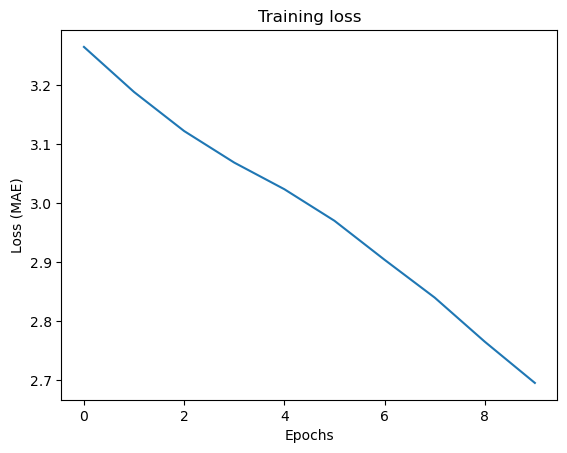

In [36]:
plt.plot(train_losses)
plt.xlabel("Epochs")
plt.ylabel("Loss (MAE)")
plt.title("Training loss")
plt.show()

In [18]:
# A set of the predicted values for comparison

print("Actual\t:\tPredicted\t:\tDiffrence")
for el in range(len(l)):
    print(float(l[el][0]), "\t:\t", float(o[el][0]), "\t:\t", float(o[el][0] - l[el][0]))

Actual	:	Predicted	:	Diffrence
13.0 	:	 12.023143768310547 	:	 -0.9768562316894531
8.0 	:	 7.0523881912231445 	:	 -0.9476118087768555
22.0 	:	 23.7950496673584 	:	 1.7950496673583984
11.0 	:	 10.127303123474121 	:	 -0.8726968765258789
15.0 	:	 14.909523963928223 	:	 -0.09047603607177734
19.0 	:	 19.951597213745117 	:	 0.9515972137451172
18.0 	:	 18.037399291992188 	:	 0.0373992919921875
15.0 	:	 15.052903175354004 	:	 0.052903175354003906
14.0 	:	 15.035238265991211 	:	 1.035238265991211
28.0 	:	 30.039779663085938 	:	 2.0397796630859375
12.0 	:	 12.84731388092041 	:	 0.8473138809204102
16.0 	:	 16.27943229675293 	:	 0.2794322967529297
23.0 	:	 21.265348434448242 	:	 -1.7346515655517578
23.0 	:	 24.823923110961914 	:	 1.823923110961914
15.0 	:	 16.493295669555664 	:	 1.493295669555664
17.0 	:	 16.891489028930664 	:	 -0.10851097106933594
12.0 	:	 14.995077133178711 	:	 2.995077133178711
30.0 	:	 30.147348403930664 	:	 0.14734840393066406
15.0 	:	 16.670658111572266 	:	 1.670658111572265

In [ ]:
# Defining the Classification model, loading it and moving it to the gpu

class CNNClassifier(nn.Module):
    def __init__(self):
        super(CNNRegressor, self).__init__()
        self.conv_layers = nn.Sequential(
            # Convolution layer 1
            nn.Conv2d(1, 10, kernel_size=28, stride=1, padding=14),  # (N, 10, 40, 168)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 10, 20, 84)
            # Convolution layer 2
            nn.Conv2d(10, 16, kernel_size=3, stride=1, padding=1),  # (N, 16, 20, 84)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 16, 10, 42)
            # Convolution layer 3
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # (N, 32, 10, 42)
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # (N, 32, 5, 21)
        )
        self.fc_layers = nn.Sequential(
            nn.Flatten(),
            # Fully connected layer 1
            nn.Linear(32 * 5 * 21, 256),
            nn.ReLU(),
            # Fully connected layer 2
            nn.Linear(256, 40),
        )

    def forward(self, x):
        # Running the convolution layers
        x = self.conv_layers(x)
        # Running the fully connected layers
        x = self.fc_layers(x)
        return x

model = CNNClassifier().to(device)
model.load_state_dict(torch.load('model.pth', weights_only=True))